### Import packages

In [20]:
from utils import plot_ann, get_stresses, get_strains, get_X_and_y, get_load_displacements, plot_load_displacement_curves, finalize_models
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

### Load & preprocess the data (load vs. displacement curves)

In [22]:
s_t_filename = "stress_time.csv"
l_d_filename = "force_disp.csv"

s_t = get_stresses(filename=s_t_filename)
l_d = get_load_displacements(filename=l_d_filename)

X, y = get_X_and_y(s_t=s_t, l_d=l_d)


/root/notebooks/notebooks/Übung/mlp_stress_strain/utils.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  l_d.loc[s:s + num_of_measurements_per_curve - 1, "curve"] = str(i)


### Inspect load displacement curves

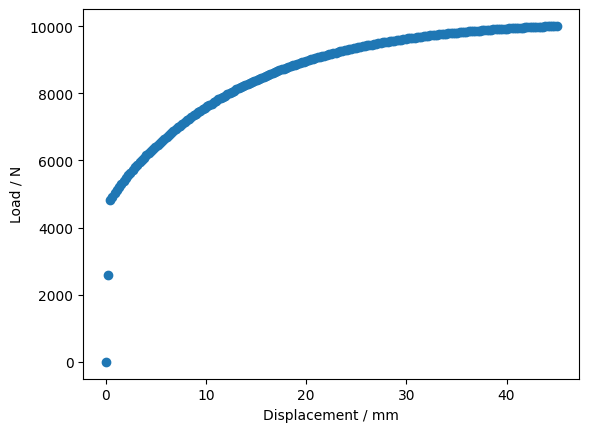

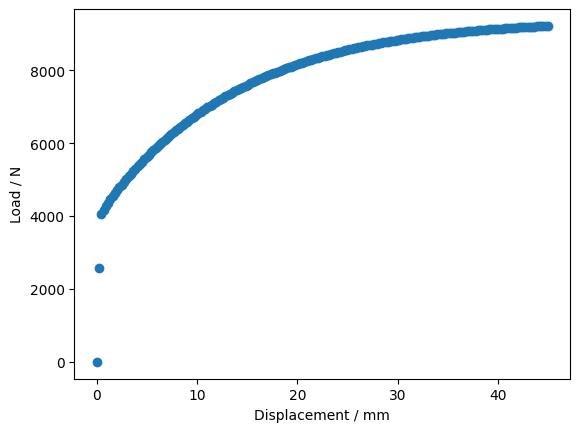

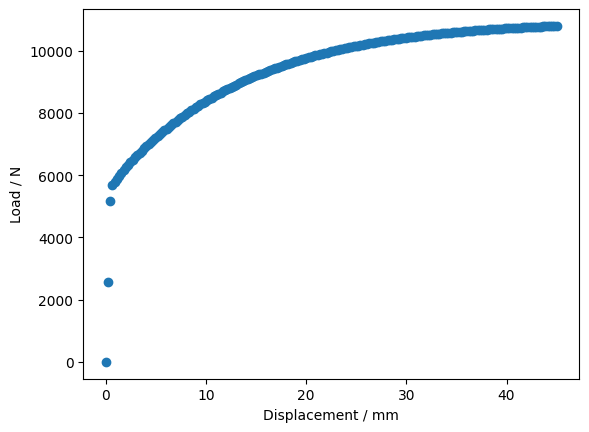

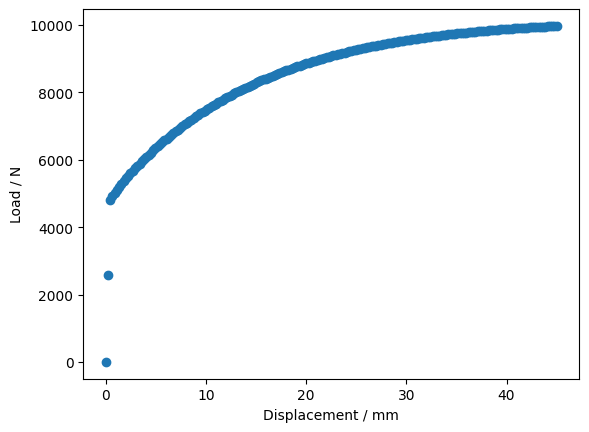

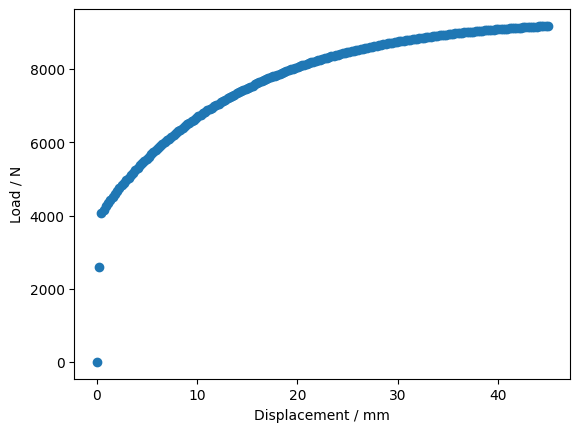

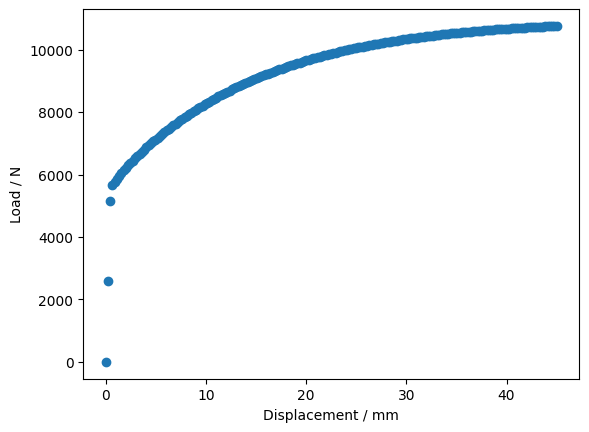

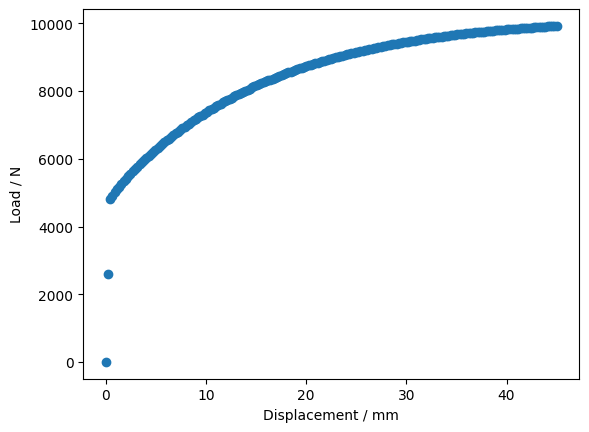

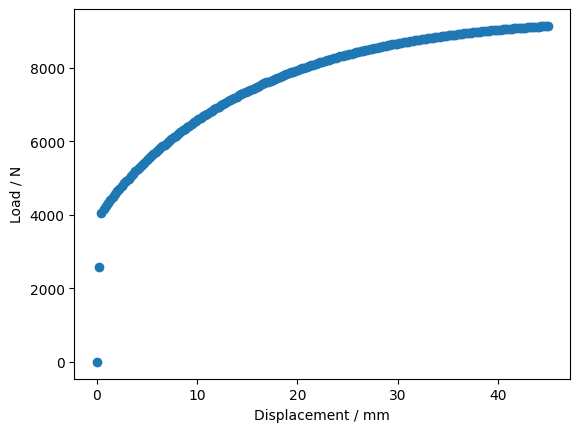

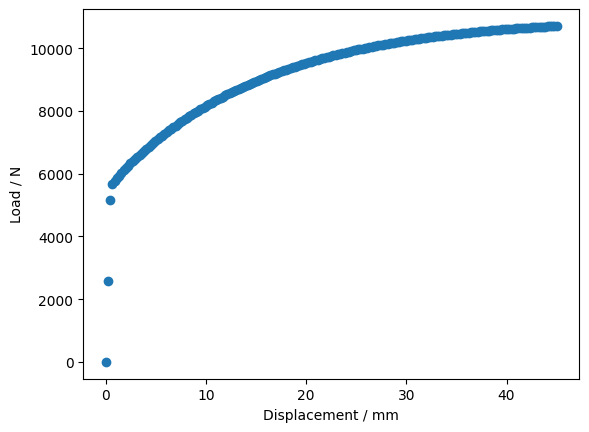

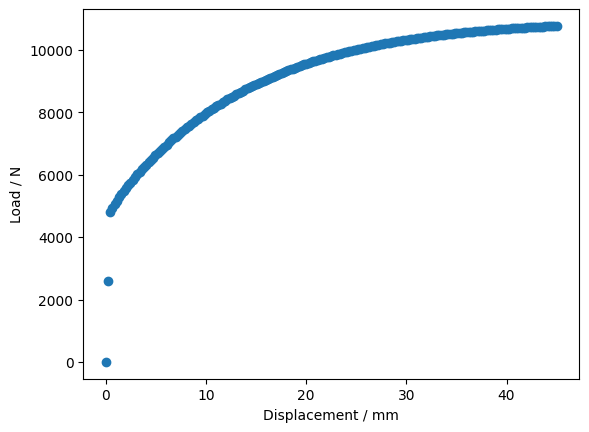

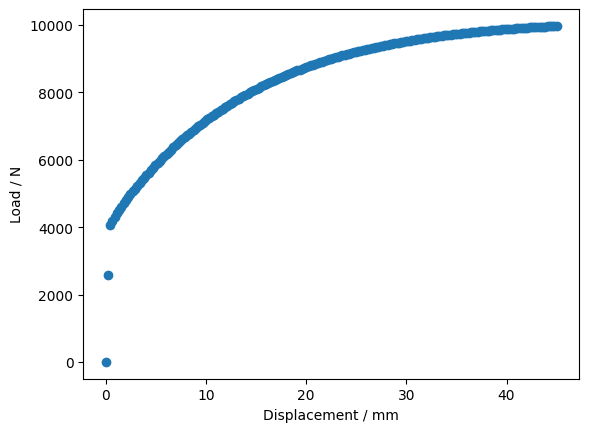

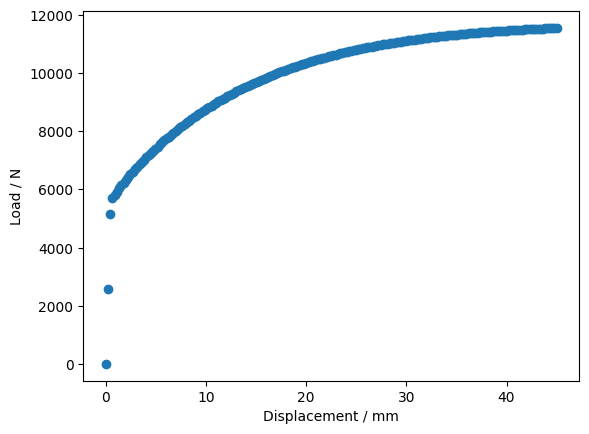

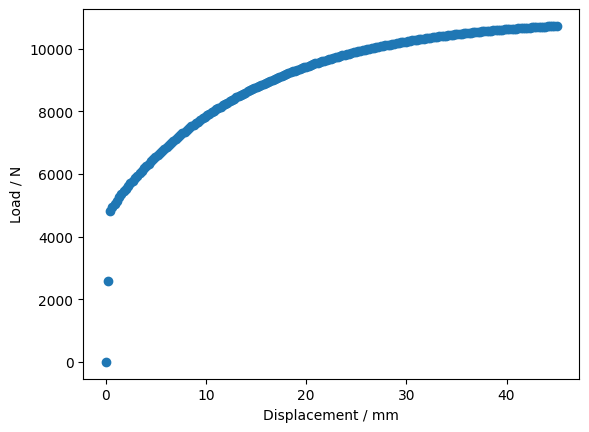

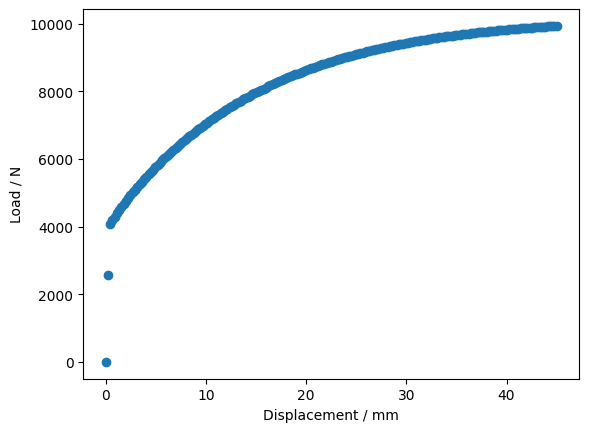

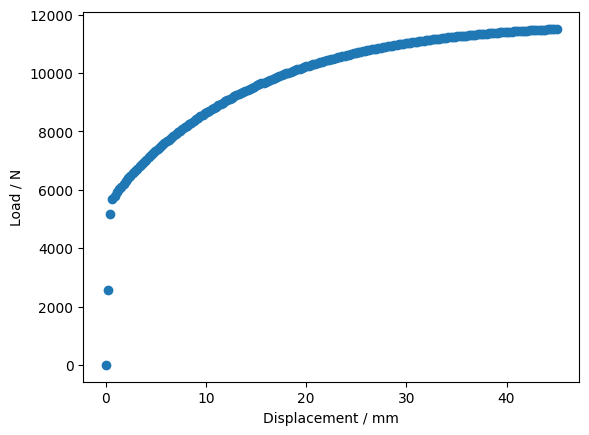

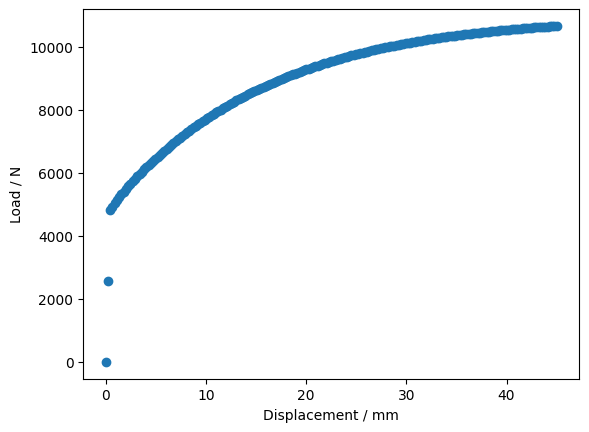

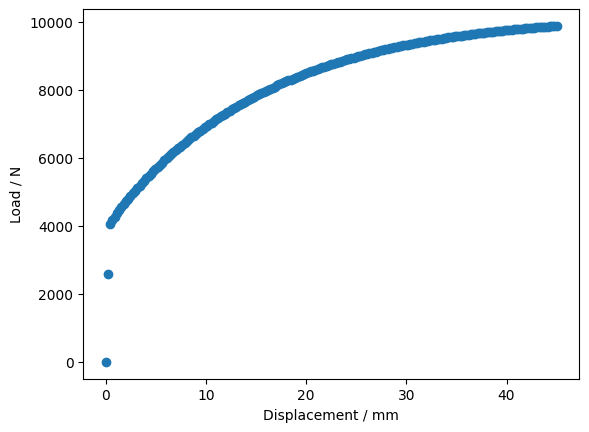

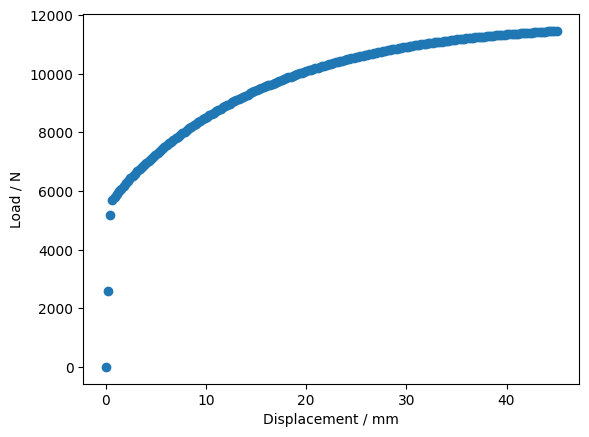

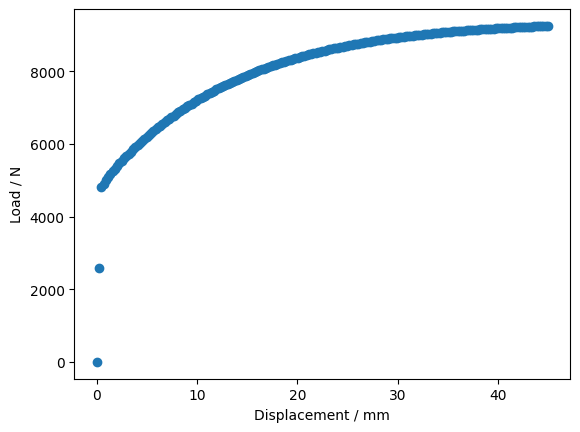

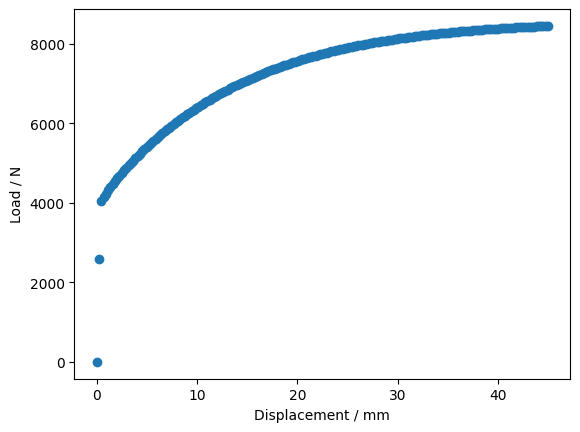

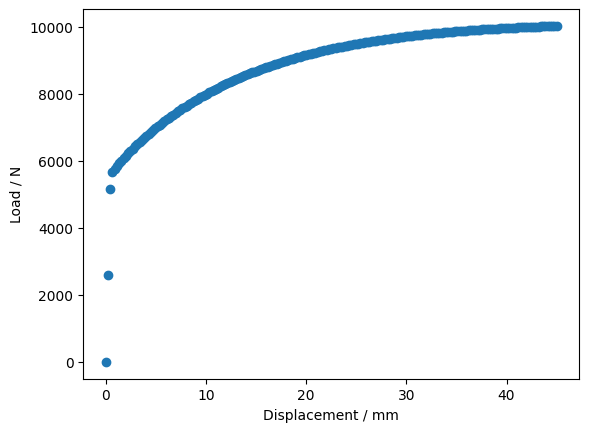

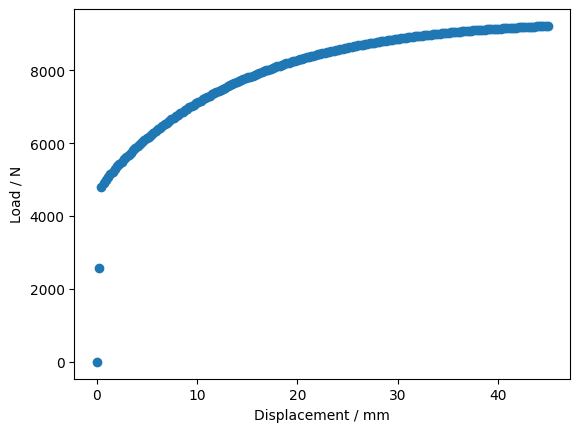

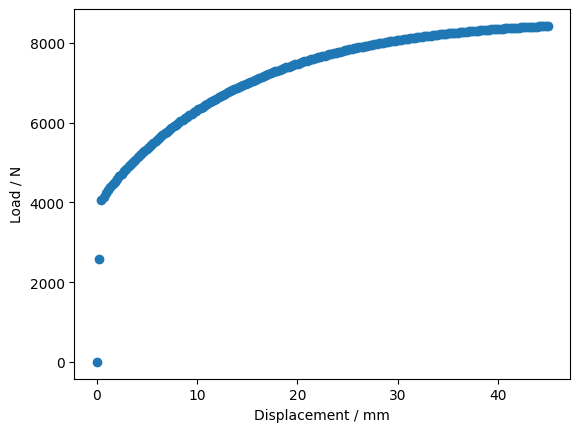

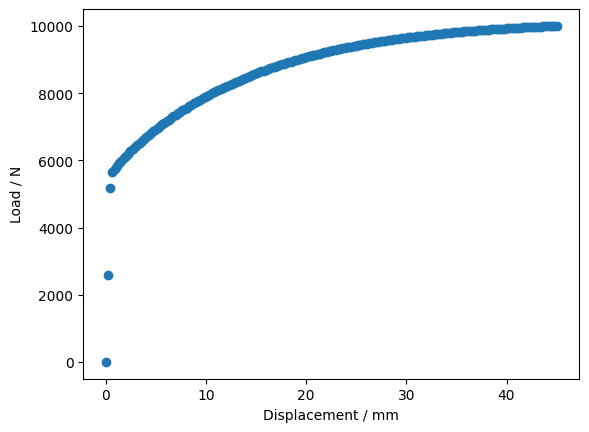

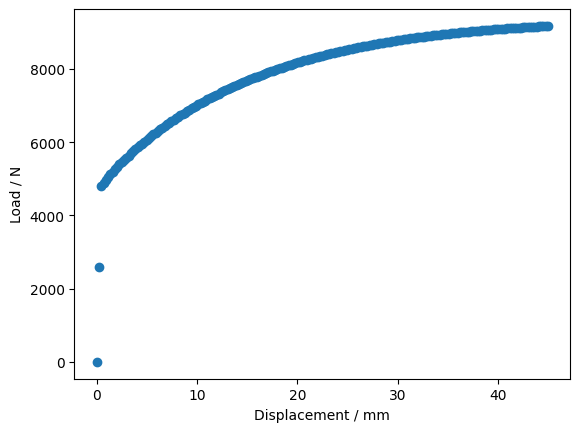

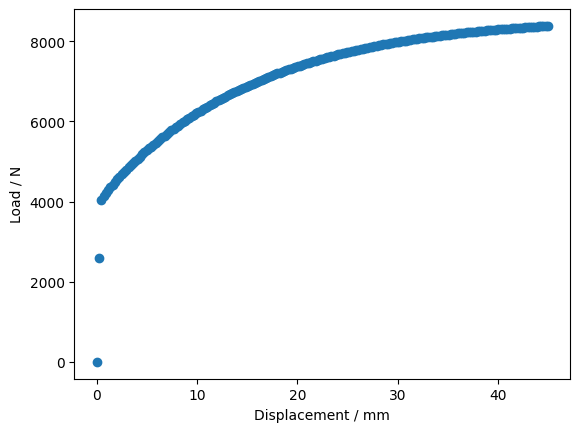

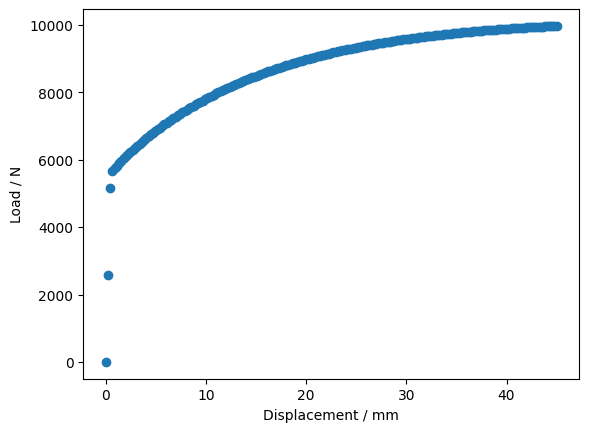

In [16]:
plot_load_displacement_curves(l_d=l_d)

### Train and validate models
This is only a showcase. In practice you would use something like GridSearchCV, RandomizedSearchCV or Bayesian optimization (optuna) and Pipeline()
to sweep many hyperparameters. The performance would be obtained by using cross validation (e.g. repeated k-fold cross validation) as a simple train/test split is more prone to overfitting.

##### split data into train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

##### scale data but only use train set for fitting the scaler to avoid information leakage (-> leaky preprocessing)

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Define models by setting hyperparameters

In [6]:
model_1 = MLPRegressor(hidden_layer_sizes=(5, 5), activation='relu', solver='adam', alpha=0.01, learning_rate_init=0.1, learning_rate='constant', random_state=7)

model_2 = MLPRegressor(hidden_layer_sizes=(5, 5), activation='relu', solver='adam', alpha=0.01, learning_rate_init=0.001, learning_rate='constant', random_state=7)

##### Train models

In [7]:
model_1.fit(X=X_train_scaled, y=y_train)
model_2.fit(X=X_train_scaled, y=y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(5, 5), random_state=7)

##### Predict test set

In [8]:
model_1_y_pred = model_1.predict(X=X_test_scaled)
model_2_y_pred = model_2.predict(X_test_scaled)

##### Calculate performance metrics (R², RMSE)

In [9]:
model_1_r2 = r2_score(y_true=y_test, y_pred=model_1_y_pred)
model_1_rmse = mean_squared_error(y_true=y_test, y_pred=model_1_y_pred)

model_2_r2 = r2_score(y_true=y_test, y_pred=model_2_y_pred)
model_2_rmse = mean_squared_error(y_true=y_test, y_pred=model_2_y_pred)

print(f"Performances of Model 1: \nR2: {model_1_r2}\nRMSE: {model_1_rmse}")
print(f"Performances of Model 2: \nR2: {model_2_r2}\nRMSE: {model_2_rmse}")

Performances of Model 1: 
R2: -0.0028430826487684246
RMSE: 0.00047889605835751823
Performances of Model 2: 
R2: 0.791540077078621
RMSE: 9.954761332040297e-05


##### Plot ANN structure and weights of both models for demonstration purposes

In [10]:
weights_of_model_1 = model_1.coefs_
weights_of_model_2 = model_2.coefs_

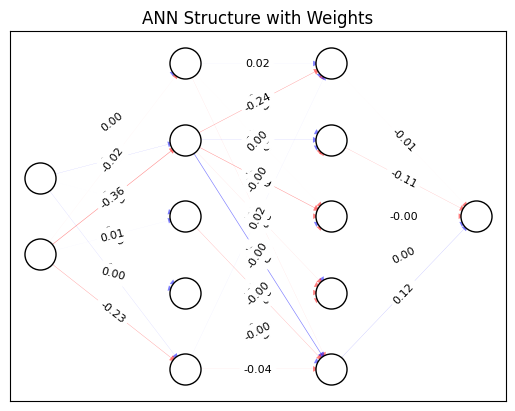

In [11]:
plot_ann(weights=weights_of_model_1, filename="weights_model_1.png")

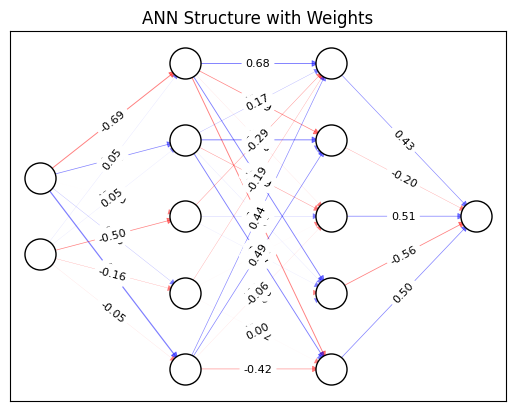

In [12]:
plot_ann(weights_of_model_2, filename="weights_of_model_2.png")

##### Finalize models by training it on all curves except curve 0 (for demonstration purposes)

In [13]:
model_1_finalized, model_2_finalized = finalize_models(X=X, y=y)

##### Demonstrate prediction ability of models with curve 0 as test set

In [14]:
curve_0_X = X.iloc[0:201]
curve_0_y = y.iloc[0:201]

scaler_0 = MinMaxScaler()
scaler_0.fit(curve_0_X)
curve_0_X_scaled = scaler_0.transform(curve_0_X)

curve_0_predicted_from_m1_f = model_1_finalized.predict(curve_0_X_scaled)
curve_0_predicted_from_m2_f = model_2_finalized.predict(curve_0_X_scaled)

m1_f_r2 = r2_score(y_true=curve_0_y, y_pred=curve_0_predicted_from_m1_f)
m2_f_r2 = r2_score(y_true=curve_0_y, y_pred=curve_0_predicted_from_m2_f)

print(f"M1_f: R2: {m1_f_r2}")
print(f"M2_f: R2: {m2_f_r2}")

M1_f: R2: -4.306841978090674
M2_f: R2: 0.9541404831302158


plot stress strain curves from FEM-Sim and finalized models for curve 0

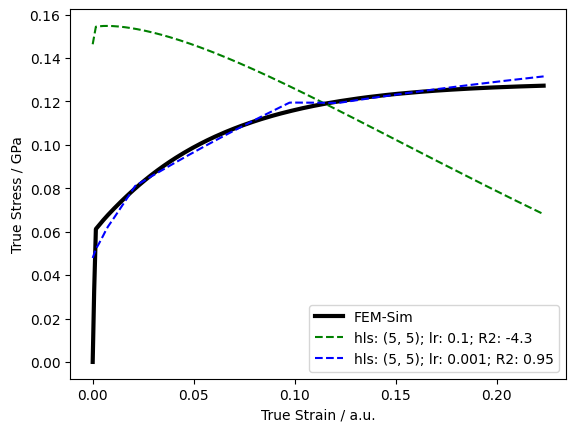

In [15]:
strains = get_strains(filename="time_strain.csv")
strain_0 = strains["0"]

fig, ax = plt.subplots()
ax.plot(strain_0, curve_0_y, color="black", linewidth=3)
ax.plot(strain_0, curve_0_predicted_from_m1_f, color="g", linestyle="--")
ax.plot(strain_0, curve_0_predicted_from_m2_f, color="b", linestyle="--")

ax.set_xlabel("True Strain / a.u.")
ax.set_ylabel("True Stress / GPa")

ax.legend(
    ["FEM-Sim", "hls: (5, 5); lr: 0.1; R2: -4.3",
     "hls: (5, 5); lr: 0.001; R2: 0.95"])



#fig.savefig("stress_strain_curve_comparison.png")
plt.show()
plt.close()